# Baseline Linear Learner Evaluation

## Import libraries

In [2]:
import json
import boto3
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Load Train Data

In [3]:
# Download the data from s3 buckets
s3 = boto3.client("s3")
data_bucket = 'ads-508-group-6-final'

data_path = "data.csv"

# downloading the test data from data_bucket
s3.download_file(data_bucket, 'churn_model_data/train/data.csv', data_path)

In [4]:
newline, bold, unbold = '\n', '\033[1m', '\033[0m'

# read the data
test_data = pd.read_csv(data_path, header=None)
test_data.columns = ['Target'] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n")

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 110673 examples and 1093 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1083,Feature_1084,Feature_1085,Feature_1086,Feature_1087,Feature_1088,Feature_1089,Feature_1090,Feature_1091,Feature_1092
0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1083.000000,1084.000000,1085.000000,1086.000000,1087.000000,1088.000000,1089.000000,1090.000000,1091.000000,1092.000
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.458333,0.000000,0.101060,0.367112,-0.222540,-0.333333,-0.313837,0.019701,0.000000,0.450
2,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.291667,-0.297297,-0.390507,-1.044013,-0.440974,-0.333333,-0.343278,-0.157604,0.000000,1.000
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.333333,-0.432432,-0.385317,0.477752,10.702828,0.166667,0.304122,0.409771,5.254663,0.400
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.458333,5.594595,5.053682,-0.206079,4.261801,5.166667,4.226595,-0.144095,4.060302,-0.425


## Quering Endpoint

In [5]:
content_type = "text/csv"
def query_endpoint(encoded_tabular_data):
    endpoint_name = 'jumpstart-ftc-sklearn-classification-linear'
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data)
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = np.array(model_predictions['probabilities'])
    return predicted_probabilities

# split the test data into smaller size of batches to query the endpoint due to the large size of test data. 
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    try:
        query_response_batch = query_endpoint(features.iloc[i:(i+batch_size), :].to_csv(header=False, index=False).encode("utf-8"))
    except Exception as e:
        if e.response is not None and 'Error' in e.response and e.response.get('Error').get('Code') == 'ModelError':
            raise Exception(
                 "Backend scripts have been updated in February '22 to standardize response "
                 "format of endpoint response."
                 "Previous endpoints may not support verbose response type used in this notebook."
                 f"To use this notebook, please launch the endpoint again. Error: {e}."
            )
        else:
            raise
    try:
        predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    except (TypeError, KeyError) as e:
        raise Exception(
              "Backend scripts have been updated in February '22 to standardize response "
              "format of endpoint response."
               "Response from previous endpoints may not be consistent with this notebook."
               f"To use this notebook, please launch the endpoint again. Error: {e}."
       )
    predict_prob.append(predict_prob_batch)
    

predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)

## Evaluating Train Data

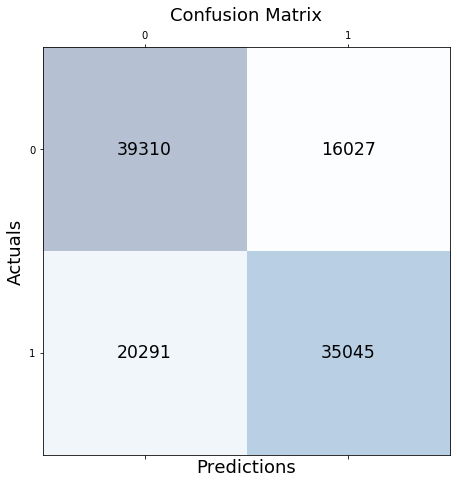

In [6]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [7]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print (
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 Macro{unbold}: {eval_f1_macro}{newline}"
    f"{bold}F1 Micro{unbold}: {eval_f1_micro}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.6718440812122198
F1 Macro: 0.6713560131422023
F1 Micro: 0.6718440812122198



## Load Validation Data

In [8]:
# Download the data from s3 buckets
s3 = boto3.client("s3")
data_bucket = 'ads-508-group-6-final'

data_path = "data.csv"

# downloading the test data from data_bucket
s3.download_file(data_bucket, 'churn_model_data/validation/data.csv', data_path)

In [9]:
newline, bold, unbold = '\n', '\033[1m', '\033[0m'

# read the data
test_data = pd.read_csv(data_path, header=None)
test_data.columns = ['Target'] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n")

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 187752 examples and 1093 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1083,Feature_1084,Feature_1085,Feature_1086,Feature_1087,Feature_1088,Feature_1089,Feature_1090,Feature_1091,Feature_1092
0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1083.000000,1084.000000,1085.000000,1086.000000,1087.000000,1088.000000,1089.000000,1090.000000,1091.000000,1092.000
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.041667,0.324324,0.084077,-0.712039,0.348596,0.000000,0.176644,0.581166,2.515626,-0.300
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.708333,-0.540541,-0.519677,-0.118404,-0.699531,-0.500000,-0.470756,-0.039401,0.000000,0.225
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.916667,-0.270270,-0.216941,0.281077,-0.449679,0.166667,0.127478,-0.015760,0.000000,-0.150
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.041667,-0.162162,-0.174145,-0.189524,-0.159987,0.666667,0.627674,0.064027,0.443668,-0.675


## Quering Endpoint

In [10]:
content_type = "text/csv"
def query_endpoint(encoded_tabular_data):
    endpoint_name = 'jumpstart-ftc-sklearn-classification-linear'
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data)
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = np.array(model_predictions['probabilities'])
    return predicted_probabilities

# split the test data into smaller size of batches to query the endpoint due to the large size of test data. 
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    try:
        query_response_batch = query_endpoint(features.iloc[i:(i+batch_size), :].to_csv(header=False, index=False).encode("utf-8"))
    except Exception as e:
        if e.response is not None and 'Error' in e.response and e.response.get('Error').get('Code') == 'ModelError':
            raise Exception(
                 "Backend scripts have been updated in February '22 to standardize response "
                 "format of endpoint response."
                 "Previous endpoints may not support verbose response type used in this notebook."
                 f"To use this notebook, please launch the endpoint again. Error: {e}."
            )
        else:
            raise
    try:
        predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    except (TypeError, KeyError) as e:
        raise Exception(
              "Backend scripts have been updated in February '22 to standardize response "
              "format of endpoint response."
               "Response from previous endpoints may not be consistent with this notebook."
               f"To use this notebook, please launch the endpoint again. Error: {e}."
       )
    predict_prob.append(predict_prob_batch)
    

predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)

## Evaluating Validation Data

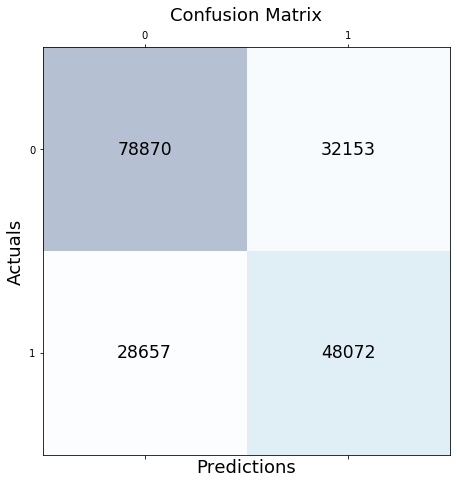

In [11]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [12]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print (
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 Macro{unbold}: {eval_f1_macro}{newline}"
    f"{bold}F1 Micro{unbold}: {eval_f1_micro}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.6761153010354084
F1 Macro: 0.6671593386340221
F1 Micro: 0.6761153010354084



## Load Test Data

In [3]:
# Download the data from s3 buckets
s3 = boto3.client("s3")
data_bucket = 'ads-508-group-6-final'

data_path = "data.csv"

# downloading the test data from data_bucket
s3.download_file(data_bucket, 'churn_model_data/test/data.csv', data_path)

In [4]:
newline, bold, unbold = '\n', '\033[1m', '\033[0m'

# read the data
test_data = pd.read_csv(data_path, header=None)
test_data.columns = ['Target'] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n")

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 187751 examples and 1093 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1083,Feature_1084,Feature_1085,Feature_1086,Feature_1087,Feature_1088,Feature_1089,Feature_1090,Feature_1091,Feature_1092
0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1083.000000,1084.000000,1085.000000,1086.000000,1087.000000,1088.000000,1.089000e+03,1090.000000,1091.0,1092.000
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.000000,-0.486486,-0.376774,2.705489,-0.699531,-0.166667,3.533857e-01,2.088258,0.0,1.000
2,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.625000,-0.054054,-0.123504,-0.423912,-0.194532,0.333333,5.984298e-01,0.630418,0.0,-0.800
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.458333,-0.135135,-0.237462,-0.696909,0.485129,0.000000,1.607045e-16,0.049251,0.0,-0.175
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.351351,0.304149,-0.166991,0.139603,-0.333333,-3.825319e-01,-0.394011,0.0,0.850


## Quering Endpoint

In [5]:
content_type = "text/csv"
def query_endpoint(encoded_tabular_data):
    endpoint_name = 'jumpstart-ftc-sklearn-classification-linear'
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data)
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = np.array(model_predictions['probabilities'])
    return predicted_probabilities

# split the test data into smaller size of batches to query the endpoint due to the large size of test data. 
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    try:
        query_response_batch = query_endpoint(features.iloc[i:(i+batch_size), :].to_csv(header=False, index=False).encode("utf-8"))
    except Exception as e:
        if e.response is not None and 'Error' in e.response and e.response.get('Error').get('Code') == 'ModelError':
            raise Exception(
                 "Backend scripts have been updated in February '22 to standardize response "
                 "format of endpoint response."
                 "Previous endpoints may not support verbose response type used in this notebook."
                 f"To use this notebook, please launch the endpoint again. Error: {e}."
            )
        else:
            raise
    try:
        predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    except (TypeError, KeyError) as e:
        raise Exception(
              "Backend scripts have been updated in February '22 to standardize response "
              "format of endpoint response."
               "Response from previous endpoints may not be consistent with this notebook."
               f"To use this notebook, please launch the endpoint again. Error: {e}."
       )
    predict_prob.append(predict_prob_batch)
    

predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)

## Evaluating Test Data

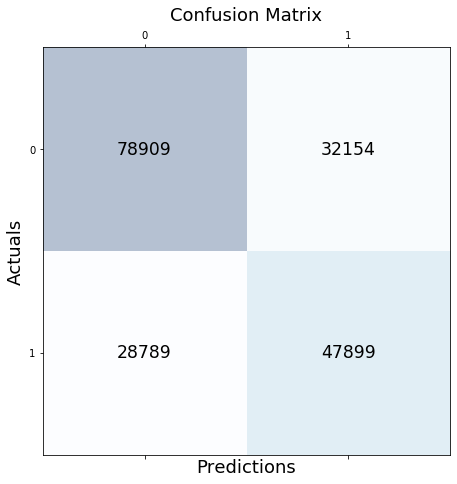

In [6]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [7]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print (
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 Macro{unbold}: {eval_f1_macro}{newline}"
    f"{bold}F1 Micro{unbold}: {eval_f1_micro}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.6754051909177581
F1 Macro: 0.6663020222500495
F1 Micro: 0.6754051909177581

